In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM

Using TensorFlow backend.


In [25]:
df = read_csv('data/train_test.csv', header=0, encoding='gbk')
df.head()

,carCommentVolum,newsReplyVolum,popularity,regMonth,regYear,adcode_110000,adcode_130000,adcode_140000,adcode_150000,adcode_210000,...,model_dff803b4024d261d,model_ea489c253676aafc,model_ef76a85c4b39f693,model_f270f6a489c6a9d7,model_f5d69960089c3614,model_f8a6975573af1b33,model_fc32b1a017b34efe,model_fde95ea242abd896,model_feabbf46658382b9,label
0,2.484907,4.672829,7.299797,1,2016,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5.680173
1,2.484907,4.672829,7.374629,1,2016,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,6.146329
2,2.484907,4.672829,7.299797,1,2016,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,5.552960
3,2.484907,4.672829,7.771067,1,2016,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,6.013715
4,2.484907,4.672829,8.178358,1,2016,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,6.415097


In [26]:
df.shape

(36960, 88)

In [27]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	#if dropnan:
		#agg.dropna(inplace=True)
	return agg

In [28]:
values = df.values
# integer encode direction
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
reframed = series_to_supervised(scaled, 0, 1)

In [29]:
reframed.head()

,var1(t),var2(t),var3(t),var4(t),var5(t),var6(t),var7(t),var8(t),var9(t),var10(t),...,var79(t),var80(t),var81(t),var82(t),var83(t),var84(t),var85(t),var86(t),var87(t),var88(t)
0,0.312575,0.470041,0.480821,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.536597
1,0.312575,0.470041,0.489723,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.591194
2,0.312575,0.470041,0.480821,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.521698
3,0.312575,0.470041,0.536885,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.575662
4,0.312575,0.470041,0.585338,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.622672


In [30]:
reframed.shape

(36960, 88)

In [31]:
values = reframed.values
n_train_hours = 25344
train = values[:n_train_hours, :]
test = values[n_train_hours:31680, :]
validation = values[31680:, :]

# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
vali_X, vali_y = validation[:, :-1], validation[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
vali_X = vali_X.reshape((vali_X.shape[0], 1, vali_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape, vali_X.shape, vali_y.shape)

(25344, 1, 87) (25344,) (6336, 1, 87) (6336,) (5280, 1, 87) (5280,)


Train on 25344 samples, validate on 6336 samples
Epoch 1/30
 - 10s - loss: 0.0292 - mean_absolute_error: 0.1022 - val_loss: 0.0055 - val_mean_absolute_error: 0.0572
Epoch 2/30
 - 7s - loss: 0.0052 - mean_absolute_error: 0.0556 - val_loss: 0.0057 - val_mean_absolute_error: 0.0588
Epoch 3/30
 - 7s - loss: 0.0050 - mean_absolute_error: 0.0538 - val_loss: 0.0049 - val_mean_absolute_error: 0.0538
Epoch 4/30
 - 7s - loss: 0.0046 - mean_absolute_error: 0.0519 - val_loss: 0.0046 - val_mean_absolute_error: 0.0525
Epoch 5/30
 - 7s - loss: 0.0043 - mean_absolute_error: 0.0503 - val_loss: 0.0044 - val_mean_absolute_error: 0.0514
Epoch 6/30
 - 7s - loss: 0.0040 - mean_absolute_error: 0.0485 - val_loss: 0.0042 - val_mean_absolute_error: 0.0508
Epoch 7/30
 - 7s - loss: 0.0037 - mean_absolute_error: 0.0462 - val_loss: 0.0041 - val_mean_absolute_error: 0.0502
Epoch 8/30
 - 7s - loss: 0.0033 - mean_absolute_error: 0.0437 - val_loss: 0.0037 - val_mean_absolute_error: 0.0481
Epoch 9/30
 - 7s - loss: 0.003

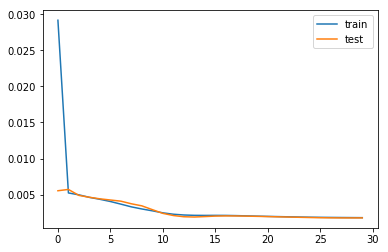

Test RMSE: 0.042


In [32]:
model = Sequential()

model.add(LSTM(64, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True))
model.add(LSTM(48, return_sequences=True))
#model.add(LSTM(128, return_sequences=True))
#model.add(Dropout(0.3))
model.add(LSTM(32))
model.add(Dense(1, activation='relu'))
model.compile(loss="mse", optimizer="adam", metrics=['mae'])
history = model.fit(train_X, train_y,batch_size=64,epochs=30,validation_data=(test_X, test_y), verbose=2, shuffle=False)


# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()
 
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

In [33]:
vali_hat = model.predict(vali_X)
vali_X = vali_X.reshape((vali_X.shape[0], vali_X.shape[2]))
# invert scaling for forecast
vali_yhat = concatenate((vali_hat, vali_X[:, 1:]), axis=1)
vali_yhat = vali_yhat[:,0]
vali_yhat.shape

(5280,)

In [34]:
new_col = ['life']
a = DataFrame(vali_yhat,columns=['forecastVolum_LSTM'])
a.to_csv('sub/predict_LSTM.csv',index=None)